# Setup

In [62]:
# Imports
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import textwrap

# Data Prep

### Import Data

In [63]:
# Read in files
files = glob.glob('Data/ProcessedData_Subject*.csv')

data_dfs = []

for filepath in files:
    df = pd.read_csv(filepath)
    
    # Extract subject number from path
    current_subject_number = filepath.split('/')[-1].split('_Subject')[1].split('.')[0].lstrip('0')
    df['Subject Number'] = current_subject_number
    data_dfs.append(df)
    
# Check
data_dfs[0].head()

,Time [s],Pressure [cmH2O],Flow [L/s],V_tidal [L],Chest [mm],Abd [mm],Inspiratory Indicies,Time (Aeration Data)_[s],Global Aeration,Inspiratory Indicies (Aeration Data),Subject Number
0,-1.000000e-02,-3.400773,0.713827,0.299421,830.612330,735.557369,407,0.02,3876.637580,203,1
1,2.275957e-15,-3.400773,0.713827,0.306559,830.644927,735.557369,929,0.04,3965.719724,464,1
2,1.000000e-02,-3.282765,0.659553,0.313426,830.710121,735.557369,1355,0.06,4075.263814,677,1
3,2.000000e-02,-3.400773,0.739471,0.320421,830.742718,735.557369,1767,0.08,4176.425315,883,1
4,3.000000e-02,-3.325677,0.739471,0.327816,830.775315,735.655851,2150,0.10,4277.385426,1075,1


In [64]:
file_path_info = glob.glob('Data/subject-info.csv')
subject_df = pd.read_csv(file_path_info[0])
subject_df.head()

,Subject Number,Sex (M/F),Height [cm],Weight [kg],Age [years],Asthma (Y/N),Medication,Dosage Frequency,History of Smoking (Y/N),Current Smoker (Y/N),...,Smoking Frequency,Time as a smoker,History of Vaping (Y/N),Current Vaper (Y/N),How long since you quit vaping,Vaping Frequency,Time as a vaper,Trial Classification,Chest Depth [mm],Chest Width [mm]
0,1,F,165.0,59,22,N,NaN,NaN,N,NaN,...,NaN,NaN,N,NaN,NaN,NaN,NaN,Normal Female,20.0,28.0
1,2,F,172.0,96,23,Y,Vannair,3-4 times daily,N,NaN,...,NaN,NaN,Y,Y,NaN,4 times daily,2 years,Asthmatic Female,25.0,33.0
2,3,F,169.0,66,24,N,NaN,NaN,N,NaN,...,NaN,NaN,N,NaN,NaN,NaN,NaN,Normal Female,22.0,30.0
3,4,M,186.0,86,22,N,NaN,NaN,N,NaN,...,NaN,NaN,N,NaN,NaN,NaN,NaN,Normal Male,27.0,38.0
4,5,M,171.0,61,30,N,NaN,NaN,Y,Y,...,3-4 times yearly,10 years,N,NaN,NaN,NaN,NaN,Normal Male,23.0,30.0


### Distributions of Dataset

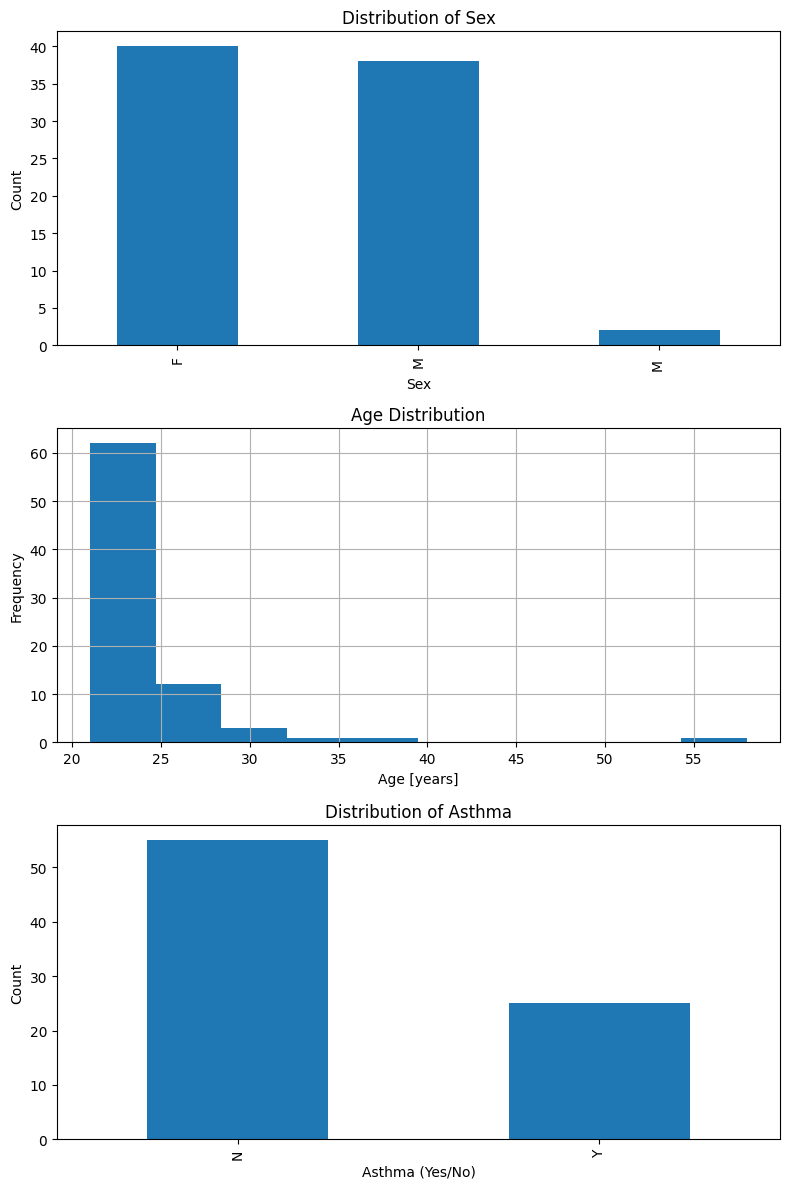

In [65]:
# 3x1 grid of plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Histogram for 'Sex (M/F)'
subject_df['Sex (M/F)'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

# Histogram for 'Age [years]'
subject_df['Age [years]'].hist(bins=10, ax=axes[1])
axes[1].set_title('Age Distribution')
axes[1].set_xlabel('Age [years]')
axes[1].set_ylabel('Frequency')

# Histogram for 'Asthma (Y/N)'
subject_df['Asthma (Y/N)'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Distribution of Asthma')
axes[2].set_xlabel('Asthma (Yes/No)')
axes[2].set_ylabel('Count')


# Display the plots
plt.tight_layout()
plt.show()

### Clean Data

In [66]:
def remove_outliers(df, columns):
    z_scores = np.abs(stats.zscore(df[columns]))
    filtered_entries = (z_scores < 4).all(axis=1)  # Relaxing the threshold to 4
    return df[filtered_entries]

def standardize(df, columns):
    scaler = StandardScaler()
    df.loc[:, columns] = scaler.fit_transform(df[columns])
    return df

processed_data_dfs = []

feat_cols = ['Pressure [cmH2O]', 'V_tidal [L]', 'Flow [L/s]']

for subject_df in data_dfs:

    # Fill missing values with forward fill
    subject_df.ffill(inplace=True)

    subject_df_clean = remove_outliers(subject_df, feat_cols)

    subject_df_standardized = standardize(subject_df_clean, feat_cols)

    processed_data_dfs.append(subject_df_standardized)

# Check
processed_data_dfs[3].head()

,Time [s],Pressure [cmH2O],Flow [L/s],V_tidal [L],Chest [mm],Abd [mm],Inspiratory Indicies,Time (Aeration Data)_[s],Global Aeration,Inspiratory Indicies (Aeration Data),Subject Number
0,-1.000000e-02,-0.268461,-0.889348,-1.457530,1034.860261,908.856548,63,0.02,5109.781175,31,4
1,-8.326673e-16,-0.261447,-0.763246,-1.460395,1034.828124,908.856548,540,0.04,5047.462647,270,4
2,1.000000e-02,-0.268461,-0.820450,-1.463102,1034.828124,908.856548,1130,0.06,4975.127715,565,4
3,2.000000e-02,-0.278982,-0.699497,-1.465662,1034.699576,908.759447,1695,0.08,4917.795526,847,4
4,3.000000e-02,-0.285997,-0.855808,-1.468304,1034.538892,908.597612,2235,0.10,4853.413981,1117,4


In [67]:
processed_data_dfs[3].describe()

,Time [s],Pressure [cmH2O],Flow [L/s],V_tidal [L],Chest [mm],Abd [mm],Inspiratory Indicies,Time (Aeration Data)_[s],Global Aeration,Inspiratory Indicies (Aeration Data)
count,118919.000000,1.189190e+05,1.189190e+05,1.189190e+05,118919.000000,118919.000000,118919.000000,118919.000000,118919.000000,118919.000000
mean,595.813293,-1.376643e-16,-3.059207e-17,1.491364e-16,1035.190456,912.107901,56.606219,214.436755,4161.160543,25.104828
std,344.803198,1.000004e+00,1.000004e+00,1.000004e+00,5.106008,4.024340,1987.144249,313.717089,5760.572242,901.759137
min,-0.010000,-4.014118e+00,-3.062328e+00,-1.804871e+00,1026.321894,895.495959,0.000000,0.000000,0.000000,0.000000
25%,297.565000,-9.207944e-01,-9.519361e-01,-7.604391e-01,1030.938869,908.758066,0.000000,0.000000,0.000000,0.000000
50%,594.860000,1.243421e-01,5.756597e-02,-1.818308e-01,1034.730793,912.642106,0.000000,0.000000,0.000000,0.000000
75%,892.155000,8.117473e-01,7.214046e-01,5.136080e-01,1038.394629,915.263832,0.000000,415.410000,7804.413238,0.000000
max,1198.330000,3.922607e+00,2.406364e+00,4.341241e+00,1052.342043,920.766221,117146.000000,1010.000000,26923.517292,50236.000000


## Plots for Visualization

### Plotting Variables over Time

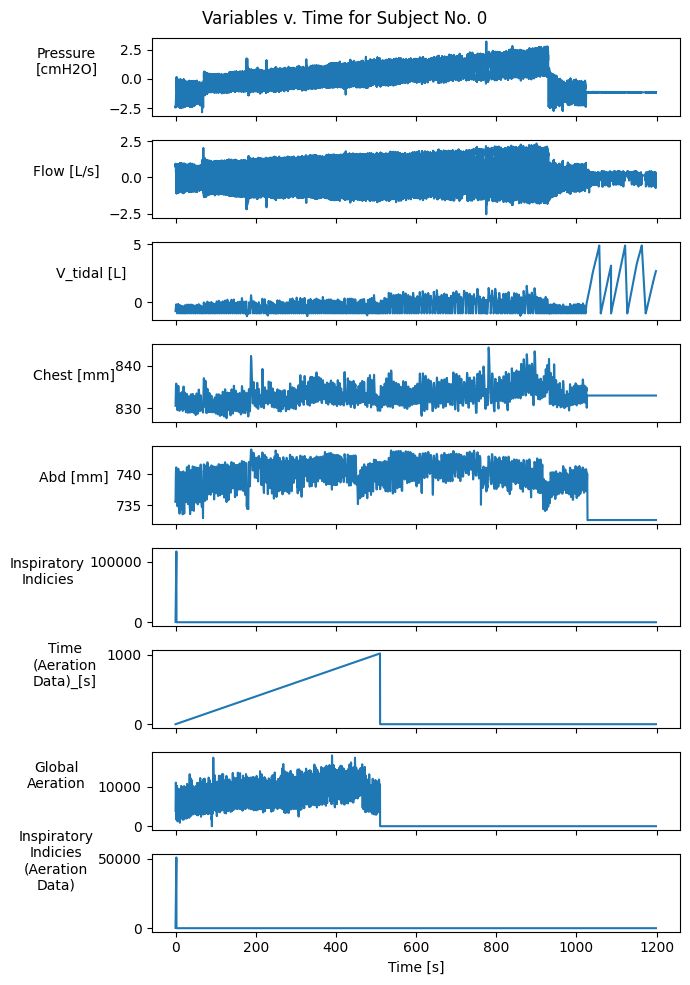

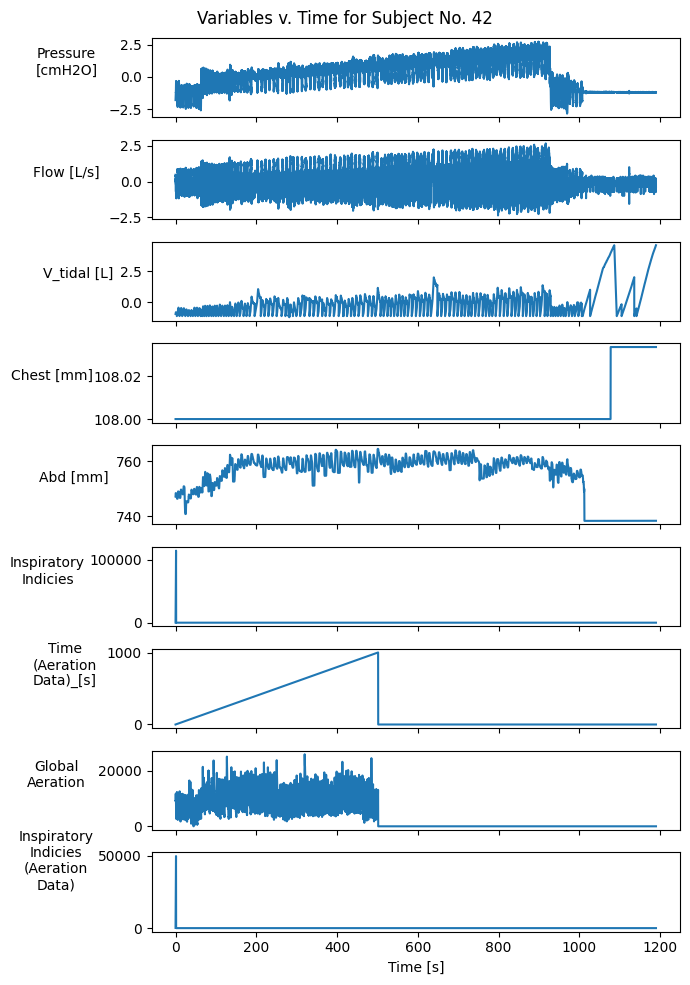

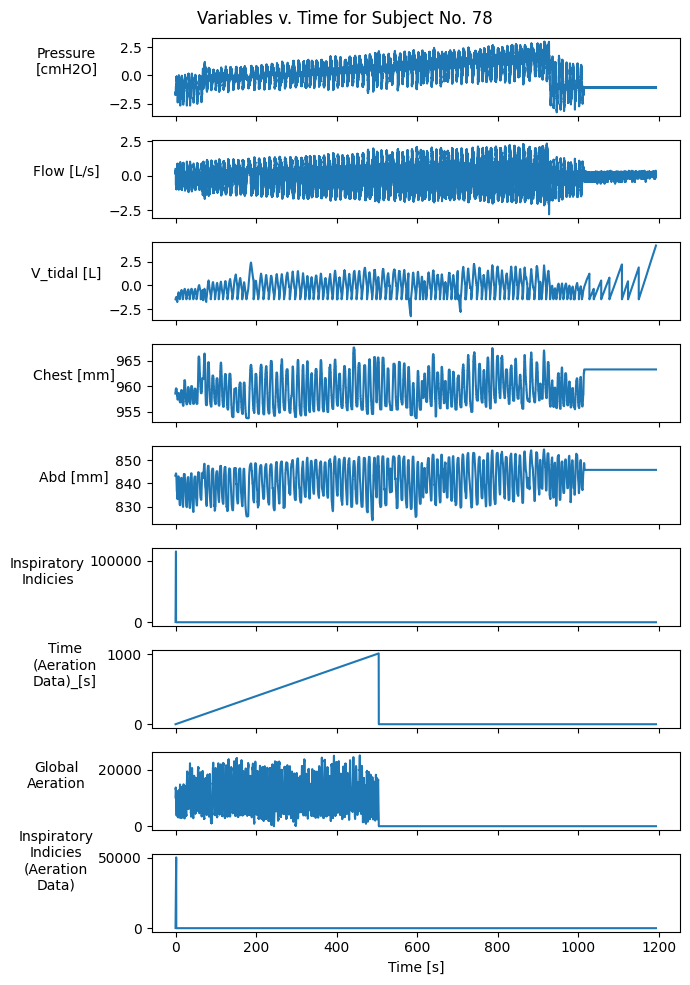

In [68]:
# List of variables to plot
variables_to_plot = [
    'Pressure [cmH2O]',
    'Flow [L/s]',
    'V_tidal [L]',
    'Chest [mm]',
    'Abd [mm]',
    'Inspiratory Indicies',
    'Time (Aeration Data)_[s]',
    'Global Aeration',
    'Inspiratory Indicies (Aeration Data)', 
]


def show_processed_plots(subject_no):
    # Read the data for the patient
    df = processed_data_dfs[subject_no].copy()

    # Convert 'Time [s]' to seconds for plotting
    df['Time [s]'] = pd.to_timedelta(df['Time [s]'], unit='s').dt.total_seconds()

    # Set the figure size and the layout for subplots
    plt.figure(figsize=(7, 10))
    plt.suptitle(f"Variables v. Time for Subject No. {subject_no}")

    # Create subplots for each variable
    for i, variable in enumerate(variables_to_plot, start=1):
        # Check if the variable/column exists in the dataframe
        if variable in df.columns:
            ax = plt.subplot(len(variables_to_plot), 1, i)
            ax.plot(df['Time [s]'], df[variable])
            ax.set_xlabel('Time [s]')
            ax.set_ylabel(variable)

            # Wrap y-axis label text
            wrapped_label = textwrap.fill(variable, width=12)
            # Set y-axis label horizontally with padding
            ax.set_ylabel(wrapped_label, rotation=0, labelpad=30)

            # Use a Linear scale and format the x-axis to show non-scientific notation
            ax.ticklabel_format(style='plain', axis='x')
            ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
            ax.xaxis.get_major_formatter().set_scientific(False)
            # Only show x-axis labels on the bottom subplot
            ax.label_outer()
        else:
            print(f"The column {variable} is not present in the file for patient {subject_no}.")

    # Adjust the layout so that all plots fit well
    plt.tight_layout()

    # Display the plots
    plt.show()


#show example plots
show_processed_plots(0)

show_processed_plots(42)

show_processed_plots(78)

### Spectrograms of Variables

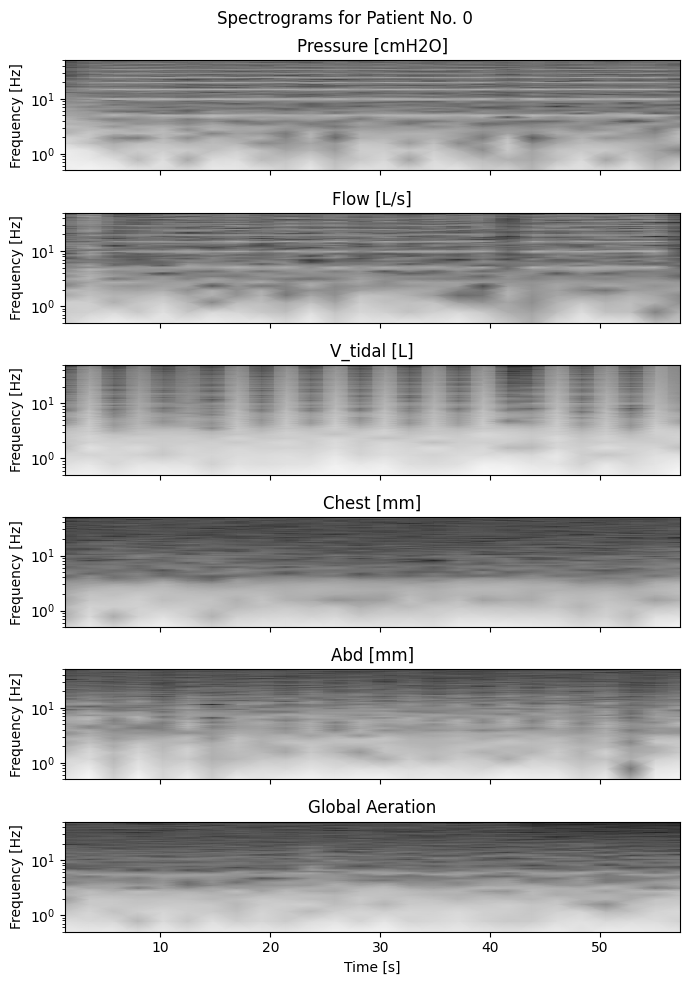

C:\Users\Ben\AppData\Local\Temp\ipykernel_11888\2111716430.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='gray') #black is low, white is high values. Log adjusted for relavent prevalence


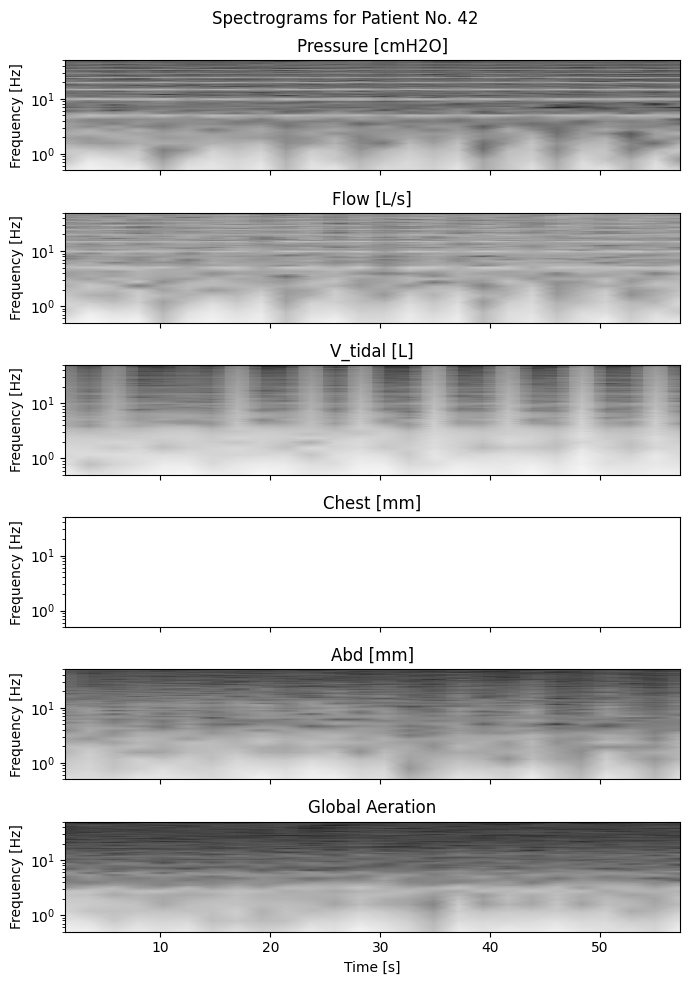

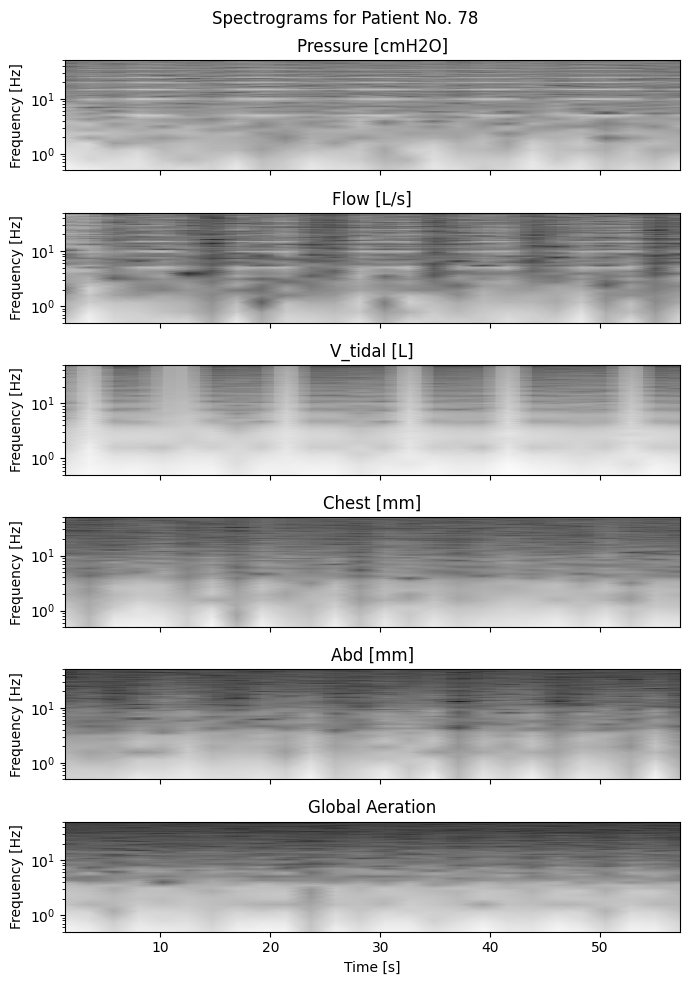

In [69]:
# List of variables to plot
variables_to_plot_2 = [
    'Pressure [cmH2O]',
    'Flow [L/s]',
    'V_tidal [L]',
    'Chest [mm]',
    'Abd [mm]',
    'Global Aeration', 
]


def show_processed_spectrograms (subject_no, start_time, stop_time):
    # Read the data for the patient
    df = processed_data_dfs[subject_no].copy()

    # Convert 'Time [s]' to seconds for plotting
    df['Time [s]'] = pd.to_timedelta(df['Time [s]'], unit='s').dt.total_seconds()

    # Filter the DataFrame to only include rows where 'Time [s]' is between time_start and time_stop
    filtered_df = df[(df['Time [s]'] >= start_time) & (df['Time [s]'] <= stop_time)]
    columns_to_keep = variables_to_plot_2 + ['Time [s]']  
    filtered_df = filtered_df[columns_to_keep].copy() 

    # Set the figure size and the layout for subplots
    plt.figure(figsize=(7, 10))

    # Create subplots for each variable
    for i, variable in enumerate(variables_to_plot_2, start=1):
        if variable in filtered_df.columns:
            f, t, Sxx = spectrogram(filtered_df[variable], fs=100)  # Assuming uniform sampling, compute mean of time differences for fs
            ax = plt.subplot(len(variables_to_plot_2), 1, i)
            plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='gray') #black is low, white is high values. Log adjusted for relavent prevalence
            ax.set_ylabel('Frequency [Hz]')
            ax.set_yscale('log')
            ax.set_ylim(0.5, 50) #50hz is maximum given 100 Hz sampling
            ax.set_xlabel('Time [s]')
            ax.label_outer()
            ax.set_title(f'{variable}')
        else:
            print(f"The column {variable} is not present in the file {filepath}.")
    

    # Main title
    plt.suptitle(f"Spectrograms for Patient No. {subject_no}")
    # Adjust the layout so that all plots fit well
    plt.tight_layout()
    # Display the plots
    plt.show()


show_processed_spectrograms(subject_no=0,start_time=65, stop_time=125)

show_processed_spectrograms(subject_no=42,start_time=65, stop_time=125)

show_processed_spectrograms(subject_no=78,start_time=65, stop_time=125)